# В этом ноутбуке

я провожу предобработку данных для обучения и предсказания:
- оцениваю нормальность распределения целевой переменной в сете для обучения и трансформирую их, чтобы ненормальность не мешала обучению;
- оцениваю нормальность распределения числовых признаков и трансформирую их; 
- оцениваю корреляцию числовых признаков между собой и с целевой переменной, схлопываю два скореллированных признака в один;
- обрабатываю категориальные признаки

Файлы 'train_df_preprocessed.csv и 'test_df_preprocessed.csv переходят в ледующий ноутбук для обучения моделей и выдачи предсказаний.

In [322]:
import numpy as np 
import pandas as pd 
np.set_printoptions(suppress=True)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
from pandas import Series

import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

from scipy.stats import norm, skew
from scipy import stats

from sklearn.preprocessing import PowerTransformer
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler

RANDOM_SEED = 42
!pip freeze > requirements.txt

import warnings
warnings.filterwarnings("ignore")

In [323]:
def save_data(title, data):
    with open(title, 'w', encoding='utf-8') as f:
        json.dump(data, f, ensure_ascii=False, indent=2)


def load_data(title):
    with open(title, encoding="utf-8") as f:
        return json.load(f)
    
def get_unique_values(non_un_list):
    return list(set(non_un_list))

def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred-y_true)/y_true))

In [324]:
test_df=pd.read_csv('test_df_cleaned.csv')
train_df=pd.read_csv('train_df_cleaned.csv')

In [325]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34686 entries, 0 to 34685
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   brand      34686 non-null  object 
 1   model      34686 non-null  object 
 2   body       34686 non-null  object 
 3   color      34686 non-null  object 
 4   engine     34686 non-null  float64
 5   transmiss  34686 non-null  object 
 6   drive      34686 non-null  object 
 7   steer      34686 non-null  object 
 8   power      34686 non-null  int64  
 9   fuel       34686 non-null  object 
 10  year       34686 non-null  int64  
 11  mileage    34686 non-null  int64  
 12  owners     34686 non-null  int64  
 13  title      34686 non-null  object 
dtypes: float64(1), int64(4), object(9)
memory usage: 3.7+ MB


In [326]:
test_df.columns

Index(['brand', 'model', 'body', 'color', 'engine', 'transmiss', 'drive',
       'steer', 'power', 'fuel', 'year', 'mileage', 'owners', 'title'],
      dtype='object')

# TARGET - price

<AxesSubplot:>

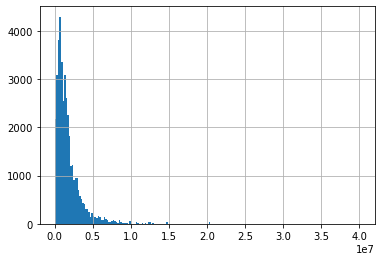

In [327]:
# Оценим распределение целевой переменной в целом
train_df['price'].hist(bins=200)

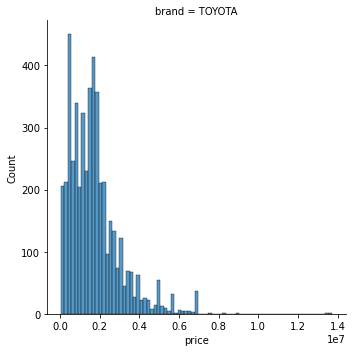

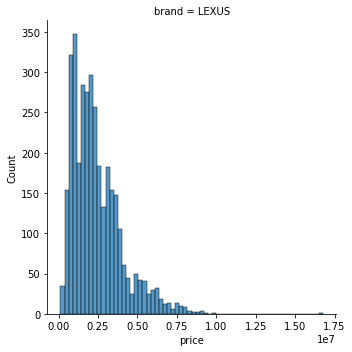

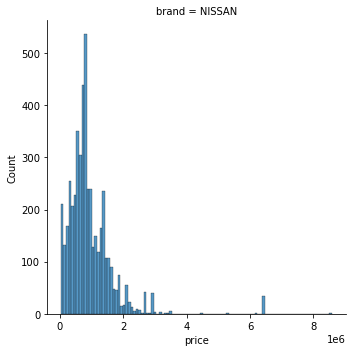

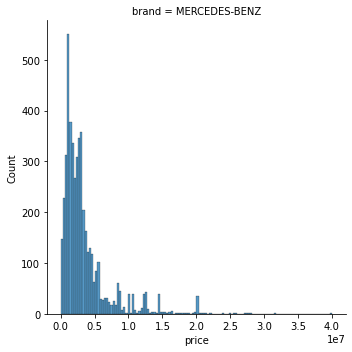

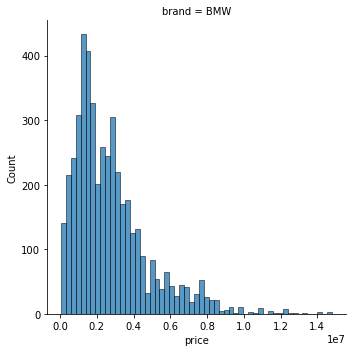

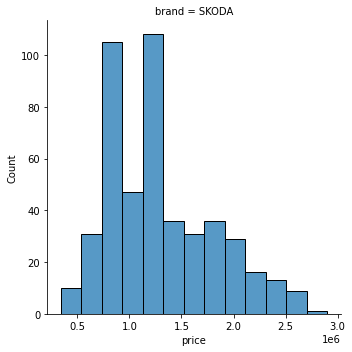

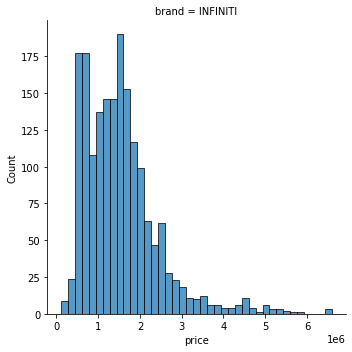

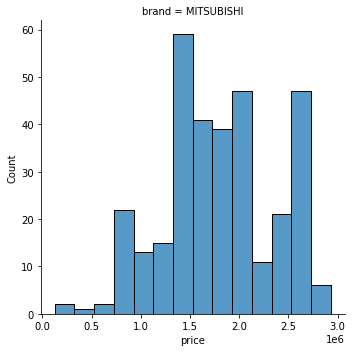

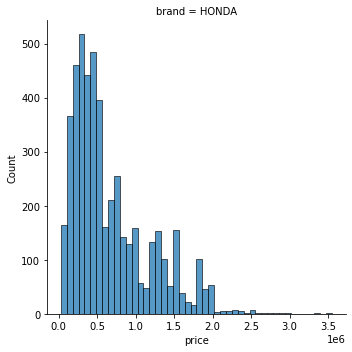

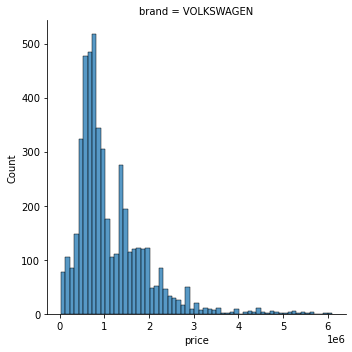

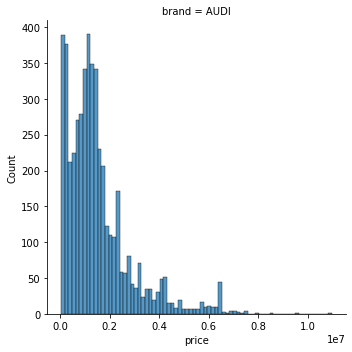

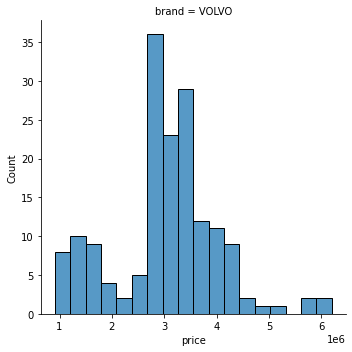

In [328]:
brands=get_unique_values(train_df['brand'])  # И отдельно по маркам
for brand in brands:
    sns.displot(train_df[train_df['brand']==brand], x="price", col="brand", multiple="dodge")

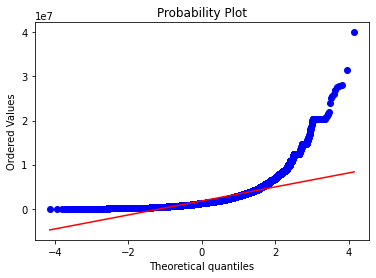

In [329]:
# quantile-quantile plot is to help us assess if a set of data plausibly came from some theoretical distribution 
# such as a Normal or exponential. https://data.library.virginia.edu/understanding-q-q-plots/#:~:text=A%20Q%2DQ%20plot%20is%20a,of%20quantiles%20against%20one%20another.&text=Q%2DQ%20plots%20take%20your%20sample,size%20of%20your%20sample%20data.

# Посмотрим на статистическую меру qq-plot, чтобы убедиться, что нам не показалось:

fig = plt.figure()
res = stats.probplot(train_df['price'], plot=plt)
plt.show()

#### ВЫВОД : Распределение явно skewed. 
#### Прологарифмируем

In [330]:
train_df['price']= np.log(train_df['price']) # Я не прибавляю 1, потому что у меня нет нулевых цен

<AxesSubplot:>

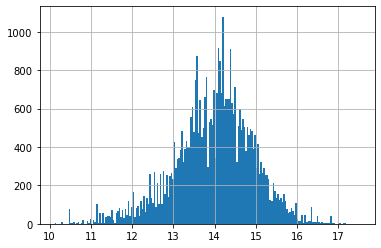

In [331]:
train_df['price'].hist(bins=200) # Вот как это выглядит теперь:

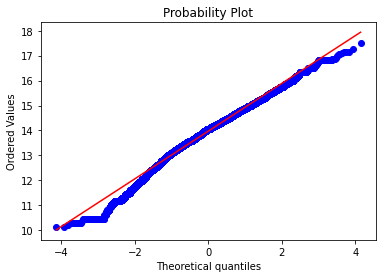

In [332]:
fig = plt.figure()
res = stats.probplot(train_df['price'], plot=plt)
plt.show()

# Numerical features

In [333]:
numerical_cols= ['engine', 'power','year', 'mileage', 'owners']

#### Протестируем отклонение от нормального распределения, используя статистические функции вместо визуализации
https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.skew.html
https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.kurtosis.html

In [334]:
skew_tr = train_df[numerical_cols].apply(lambda feature: feature.skew(), axis=0)
kurt_tr = train_df[numerical_cols].apply(lambda feature: feature.kurt(), axis=0)
skew_tst = test_df[numerical_cols].apply(lambda feature: feature.skew(), axis=0)
kurt_tst = test_df[numerical_cols].apply(lambda feature: feature.kurt(), axis=0)
skew_kurt = pd.concat([skew_tr, kurt_tr, skew_tst, kurt_tst ], axis=1)
skew_kurt.columns=['skew_train','kurt_train','skew_test','kurt_test' ]
display(skew_kurt)

,skew_train,kurt_train,skew_test,kurt_test
engine,1.280,1.569,1.397,1.907
power,1.586,3.351,1.691,3.967
year,-1.606,4.618,-1.387,5.256
mileage,1.183,2.819,1.270,4.562
owners,-0.092,-1.666,-0.363,-1.474


#### Данные заметно skewed, все показатели skew или сильно больше, или близки к 1 (-1), кроме кол-ва владельцев в тестовом сете
Хвосты (kurtoises) cильные признакам:
год производства (у нас там есть несколько старых машин, хотя и нет откровенного антиквариата, а хотелось бы, в тестовом есть парочка);
мощность (лошадиные силы), у нас есть несколько мощных машин в сете; в тестовом сете сильный хвост по пробегу машин. Отрицательные значения просто показывют, что хвост слева, машин, у которых владельцев было только 1, больше, чем тех, у которых 3.

In [335]:
# PowerTRansformer    https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PowerTransformer.html

train_df['engine']=train_df['engine'].apply(lambda x: 0.0005 if x<=0 else x) #Наши электродвигатели тут немного выстреливают
test_df['engine']=train_df['engine'].apply(lambda x: 0.0005 if x<=0 else x)  #Для Box Cox нужны строго неотрицательные данные

pt=PowerTransformer(method='box-cox')

train_df[numerical_cols] = pt.fit_transform(train_df[numerical_cols])
test_df[numerical_cols] = pt.fit_transform(test_df[numerical_cols])

#### Для трансформации данных мною были опробованы варианты ниже, но они не дали нужного результата.

#### А вот PowerTranformer справился на ура.


#### scipy boxcox - Отвергнут, давал nan  в колонке year

train_df['engine']=train_df['engine'].apply(lambda x: 0.0005 if x<=0 else x)
test_df['engine']=train_df['engine'].apply(lambda x: 0.0005 if x<=0 else x)

from scipy.stats import boxcox

for col in numerical_cols:
    print(col)
    train_df[col], lmbda = boxcox(train_df[col], lmbda=None) 
    print(col)
    test_df[col], lmbda = boxcox(test_df[col], lmbda=None)

#### Логарифмирование - не справилось с приведением к нормальному распределению

for col in numerical_cols:
    train_df[col] = np.log1p(train_df[col]+1)   
    test_df[col] = np.log1p(test_df[col]+1)

In [336]:
# Показатели после трансформации данных:

skew_tr = train_df[numerical_cols].apply(lambda feature: feature.skew(), axis=0)
kurt_tr = train_df[numerical_cols].apply(lambda feature: feature.kurt(), axis=0)
skew_tst = test_df[numerical_cols].apply(lambda feature: feature.skew(), axis=0)
kurt_tst = test_df[numerical_cols].apply(lambda feature: feature.kurt(), axis=0)
skew_kurt = pd.concat([skew_tr, kurt_tr, skew_tst, kurt_tst ], axis=1)
skew_kurt.columns=['skew_train','kurt_train','skew_test','kurt_test' ]
display(skew_kurt)

,skew_train,kurt_train,skew_test,kurt_test
engine,0.327,2.439,0.329,2.422
power,-0.005,0.309,0.002,-0.028
year,-0.933,0.725,-0.643,0.311
mileage,-0.079,0.095,-0.013,0.466
owners,-0.173,-1.650,-0.307,-1.524


### Посмотрим, как числовые признаки коррелируют между собой и с целевой переменной

In [337]:
test_df[numerical_cols].corr(method='pearson')

,engine,power,year,mileage,owners
engine,1.000,-0.088,-0.019,0.041,0.012
power,-0.088,1.000,0.263,-0.205,-0.033
year,-0.019,0.263,1.000,-0.717,-0.536
mileage,0.041,-0.205,-0.717,1.000,0.483
owners,0.012,-0.033,-0.536,0.483,1.000


In [338]:
train_df[(numerical_cols+['price'])].corr(method='pearson')

,engine,power,year,mileage,owners,price
engine,1.000,0.800,0.014,0.022,0.094,0.415
power,0.800,1.000,0.271,-0.194,-0.015,0.633
year,0.014,0.271,1.000,-0.737,-0.530,0.771
mileage,0.022,-0.194,-0.737,1.000,0.508,-0.675
owners,0.094,-0.015,-0.530,0.508,1.000,-0.432
price,0.415,0.633,0.771,-0.675,-0.432,1.000


<AxesSubplot:>

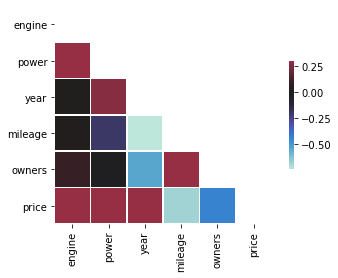

In [339]:
corr=train_df[(numerical_cols+['price'])].corr(method='pearson')
mask = np.triu(np.ones_like(corr, dtype=bool)) # mask for the upper triangle
sns.heatmap(corr, mask=mask, vmax=.3, center=0,   
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

#### Интересно, что в тестовом сете объём двигателя и мощность не коррелируют между собой, как в тренинговом.
#### Это может отразиться на качестве предсказания. Уберу-ка я колонку engine вообще, её корреляция с ценой
#### меньше, чем у мощности.

In [340]:
train_df.drop('engine', axis=1, inplace=True)
test_df.drop('engine',axis=1, inplace=True)

##### Вполне естественно, что 
#####          - пробег и год выпуска 
#####          - объём двигателя и мощность (в тренинговом сете)
##### скоррелированы. 
##### Применю PCA  к паре пробег/год. 


In [341]:
pca = PCA(n_components=1,svd_solver='full')
train_df['mile_year']=pca.fit_transform(train_df[['mileage','year']].values)
test_df['mile_year']=pca.fit_transform(test_df[['mileage','year']].values)
train_df.drop(['mileage','year'], axis=1, inplace=True)
test_df.drop(['mileage','year'],axis=1, inplace=True)

## Categorical features

In [342]:
categorical_cols=['brand', 'model', 'body', 'color',  'transmiss', 'drive',
       'steer',  'fuel', 'title']

In [343]:
train_df[categorical_cols].describe()

,brand,model,body,color,transmiss,drive,steer,fuel,title
count,40268,40268,40268,40268,40268,40268,40268,40268,40268
unique,12,410,24,16,4,3,2,5,2
top,AUDI,RX,внедорожник 5 дв.,чёрный,автоматическая,полный,Левый,бензин,Оригинал
freq,4919,1275,18047,12580,24120,20989,37153,31597,34966


In [344]:
test_df[categorical_cols].describe()

,brand,model,body,color,transmiss,drive,steer,fuel,title
count,34686,34686,34686,34686,34686,34686,34686,34686,34686
unique,12,452,24,16,4,3,2,5,2
top,BMW,OCTAVIA,седан,чёрный,автоматическая,передний,Левый,бензин,Оригинал
freq,4473,1455,13147,11010,19596,15565,33287,28601,30099


#### Вах, у нас в обучающем сете преобладают внедорожники, а в тестовом - седаны. И моделей в тестовом сете больше, чем в обучающем.

В основном все признаки в обоих сетах синхронизированы на этапе чистки данных

##### Из-за несовпадения количества моделей в тестовом и тренинговом сетах придётся их объединить для Label_Encoding

In [345]:
l_enc=LabelEncoder()

test_df['price']='price'
concatenated_df=pd.concat([test_df,train_df], axis=0)

classes_from_Label_Encoding={}  #Сохраним исходные наименования признаков, на всякий случай

for column in categorical_cols:
    print(column)
    concatenated_df[column] = l_enc.fit_transform(concatenated_df[column])
    classes_from_Label_Encoding.update({column : dict(enumerate(l_enc.classes_)) })  # Пригодятся

concatenated_df[categorical_cols].head()


brand
model
body
color
transmiss
drive
steer
fuel
title


,brand,model,body,color,transmiss,drive,steer,fuel,title
0,8,293,8,13,3,1,0,0,1
1,8,293,8,15,2,1,0,0,1
2,8,426,8,12,3,1,0,0,1
3,8,293,8,6,0,1,0,0,1
4,8,293,8,1,0,1,0,0,1


In [346]:
display(test_df.shape)
display(train_df.shape)
test_df=concatenated_df[concatenated_df['price']=='price'].copy()
test_df.drop(['price'], axis=1, inplace=True)
train_df=concatenated_df[concatenated_df['price']!='price'].copy()
display(test_df.shape)
display(train_df.shape)

(34686, 13)

(40268, 13)

(34686, 12)

(40268, 13)

<AxesSubplot:>

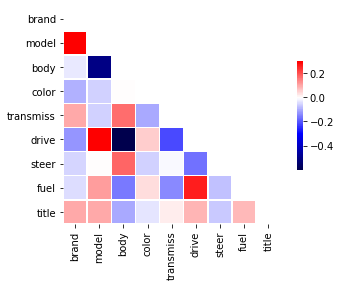

In [353]:
corr=train_df[['brand', 'model', 'body', 'color',  'transmiss', 'drive',
               'steer',  'fuel', 'title', 'price']].corr(method='spearman')

mask = np.triu(np.ones_like(corr, dtype=bool)) # mask for the upper triangle

sns.heatmap(corr, mask=mask, vmax=.3, center=0, cmap='seismic',   
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

#### Не вижу поводов для беспокойства

In [348]:
# Продолжение следует...

train_df.to_csv('train_df_preprocessed.csv',index=False)  # Save the dataframe

test_df.to_csv('test_df_preprocessed.csv',index=False)  # Save the dataframe

In [347]:
# train_df['price']= np.exp(train_df['price']) НЕ ЗАБЫТЬ